3.1 Importacion de datos

In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 1. Configuración
sns.set_style("whitegrid")
BASE_DIR = Path.cwd().parent
PROCESSED_DIR = BASE_DIR / "data" / "processed"

print("--- SCRIPT 1: CARGA Y PREPARACIÓN FINAL ---")

# 2. Carga
df_train = pd.read_parquet(PROCESSED_DIR / "final_train_con_gestiones.parquet")
df_oot = pd.read_parquet(PROCESSED_DIR / "final_oot_con_gestiones.parquet")

# Forzamos los IDs a string inmediatamente para evitar el redondeo (pérdida de precisión)
if 'id_masked' in df_train.columns:
    df_train['id_masked'] = df_train['id_masked'].astype(str)

# En OOT buscamos 'ID' o 'id_masked' y lo fijamos como string
id_col_oot = 'ID' if 'ID' in df_oot.columns else 'id_masked'
df_oot[id_col_oot] = df_oot[id_col_oot].astype(str)

# Si el OOT usa 'ID', creamos un alias para que el script no rompa
if id_col_oot == 'ID':
    df_oot['id_masked'] = df_oot['ID']
# ----------------------------------

# 3. LIMPIEZA DE TIPOS
print(" Limpiando tipos de datos para XGBoost...")

# Identificar columnas de texto (excluyendo el ID que ya es string)
cols_texto = df_train.select_dtypes(include=['object', 'string']).columns.tolist()
cols_texto = [c for c in cols_texto if c not in ['id_masked', 'ID']]

for col in cols_texto:
    # Solo convertimos si la columna existe en AMBOS datasets
    if col in df_train.columns and col in df_oot.columns:
        df_train[col] = df_train[col].astype('category')
        df_oot[col] = df_oot[col].astype('category')
    # Si solo está en Train, solo ahí
    elif col in df_train.columns:
        df_train[col] = df_train[col].astype('category')

# B. Definir columnas a ignorar
target_col = 'target'
ignore_cols = [
    target_col, 'id_masked', 'ID', 'mejor_canal_contacto', 
    'fecha_proceso', 'max_fecha_proceso', 'fecha_mes', 'fin_mes', 'month_key'
]

# 4. Selección de Features final
features = [c for c in df_oot.columns if c not in ignore_cols]

X = df_train[features]
y = df_train[target_col]
X_oot = df_oot[features]

print(f" Listo. Variables finales: {len(features)}")

--- SCRIPT 1: CARGA Y PREPARACIÓN FINAL ---
 Limpiando tipos de datos para XGBoost...
 Listo. Variables finales: 45


3.2 Definición del Framework de Entrenamiento

In [12]:
print("--- SCRIPT 2: PREPARACIÓN DEL ENTRENAMIENTO ---")

# 1. Split (80% Entrenamiento / 20% Validación)
# Usamos stratify=y para que ambos grupos tengan la misma proporción de éxitos
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.20, 
    random_state=42, 
    stratify=y
)

print(f"Dimensiones del Split:")
print(f"   - Train: {X_train.shape} (Donde el modelo aprende)")
print(f"   - Val:   {X_val.shape}   (Donde el modelo hace el examen)")

# 2. Cálculo de Pesos para el Desbalance
# Fórmula: (Negativos / Positivos)
ratio_negativos = (y_train == 0).sum()
ratio_positivos = (y_train == 1).sum()
scale_pos_weight = ratio_negativos / ratio_positivos

print(f"\nBalanceo de Clases:")
print(f"   - Negativos (0): {ratio_negativos}")
print(f"   - Positivos (1): {ratio_positivos}")
print(f"   - Scale Pos Weight calculado: {scale_pos_weight:.2f}")

--- SCRIPT 2: PREPARACIÓN DEL ENTRENAMIENTO ---
Dimensiones del Split:
   - Train: (161581, 45) (Donde el modelo aprende)
   - Val:   (40396, 45)   (Donde el modelo hace el examen)

Balanceo de Clases:
   - Negativos (0): 142115
   - Positivos (1): 19466
   - Scale Pos Weight calculado: 7.30


In [13]:
print("--- SCRIPT 3: ENTRENAMIENTO DEL MODELO ---")

# 1. Configuración del Modelo
# Movemos early_stopping_rounds y eval_metric aquí arriba
clf = xgb.XGBClassifier(
    n_estimators=1000,          
    learning_rate=0.05,         
    max_depth=6,                
    subsample=0.8,              
    colsample_bytree=0.8,       
    scale_pos_weight=7.30,       
    random_state=42,
    n_jobs=-1,                  
    enable_categorical=True,
    early_stopping_rounds=50,
    eval_metric=["auc", "logloss"]
)

# 2. Entrenamiento
print(" Entrenando XGBoost...")

clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=50
)

print(f"\n✅ ¡Entrenamiento completado!")
print(f"Mejor iteración: {clf.best_iteration}")

--- SCRIPT 3: ENTRENAMIENTO DEL MODELO ---
 Entrenando XGBoost...
[0]	validation_0-auc:0.78473	validation_0-logloss:0.68063	validation_1-auc:0.77750	validation_1-logloss:0.68078
[50]	validation_0-auc:0.80588	validation_0-logloss:0.54591	validation_1-auc:0.79286	validation_1-logloss:0.55137
[100]	validation_0-auc:0.81458	validation_0-logloss:0.53301	validation_1-auc:0.79501	validation_1-logloss:0.54268
[150]	validation_0-auc:0.82080	validation_0-logloss:0.52577	validation_1-auc:0.79528	validation_1-logloss:0.53890
[200]	validation_0-auc:0.82639	validation_0-logloss:0.51907	validation_1-auc:0.79501	validation_1-logloss:0.53552
[250]	validation_0-auc:0.83182	validation_0-logloss:0.51297	validation_1-auc:0.79461	validation_1-logloss:0.53251
[300]	validation_0-auc:0.83685	validation_0-logloss:0.50721	validation_1-auc:0.79401	validation_1-logloss:0.52971
[350]	validation_0-auc:0.84188	validation_0-logloss:0.50159	validation_1-auc:0.79333	validation_1-logloss:0.52712
[400]	validation_0-auc:0.

3.4 Diagnóstico y Evaluación del Desempeño

--- SCRIPT 4: EVALUACIÓN DE DESEMPEÑO ---
AUC-ROC Score Real: 0.7832

 Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82     35530
           1       0.26      0.71      0.38      4866

    accuracy                           0.72     40396
   macro avg       0.60      0.72      0.60     40396
weighted avg       0.86      0.72      0.77     40396



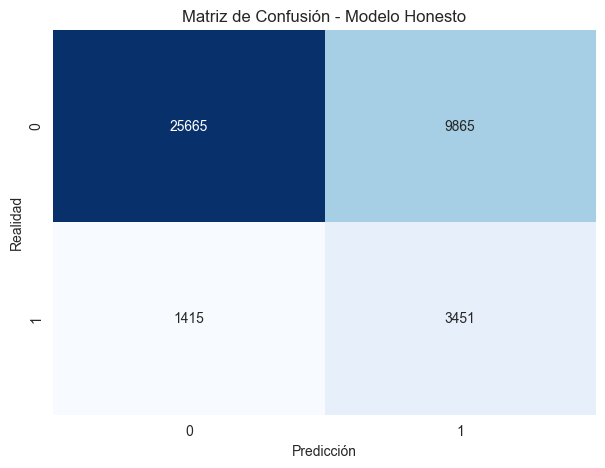


 Modelo guardado con éxito
Ruta: c:\Users\Nicole\Documents\Proyecto_BA\models\mejor_modelo_xgb.joblib


In [14]:
print("--- SCRIPT 4: EVALUACIÓN DE DESEMPEÑO ---")

# 1. Generar predicciones sobre el set de Validación
# Usamos el mejor modelo encontrado durante el entrenamiento
y_pred_proba = clf.predict_proba(X_val)[:, 1]
y_pred = clf.predict(X_val)

# 2. Calcular Métricas
auc_score = roc_auc_score(y_val, y_pred_proba)
print(f"AUC-ROC Score Real: {auc_score:.4f}")

print("\n Reporte de Clasificación:")
print(classification_report(y_val, y_pred))

# 3. Matriz de Confusión
plt.figure(figsize=(7, 5))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Modelo Honesto')
plt.ylabel('Realidad')
plt.xlabel('Predicción')
plt.show()

import joblib

# 4. GUARDADO DEL MODELO
# Definimos la ruta de la carpeta de modelos
MODELS_DIR = BASE_DIR / "models"
MODELS_DIR.mkdir(exist_ok=True) # Crea la carpeta si no existe

# Guardamos el modelo con un nombre descriptivo
model_path = MODELS_DIR / "mejor_modelo_xgb.joblib"
joblib.dump(clf, model_path)

print(f"\n Modelo guardado con éxito")
print(f"Ruta: {model_path}")

3.5 Analisis de relevancia de variables en el modelo

--- SCRIPT 5: Relevancia de variables ---


C:\Users\Nicole\AppData\Local\Temp\ipykernel_38548\1695755219.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances.head(20), x='importance', y='feature', palette='viridis')


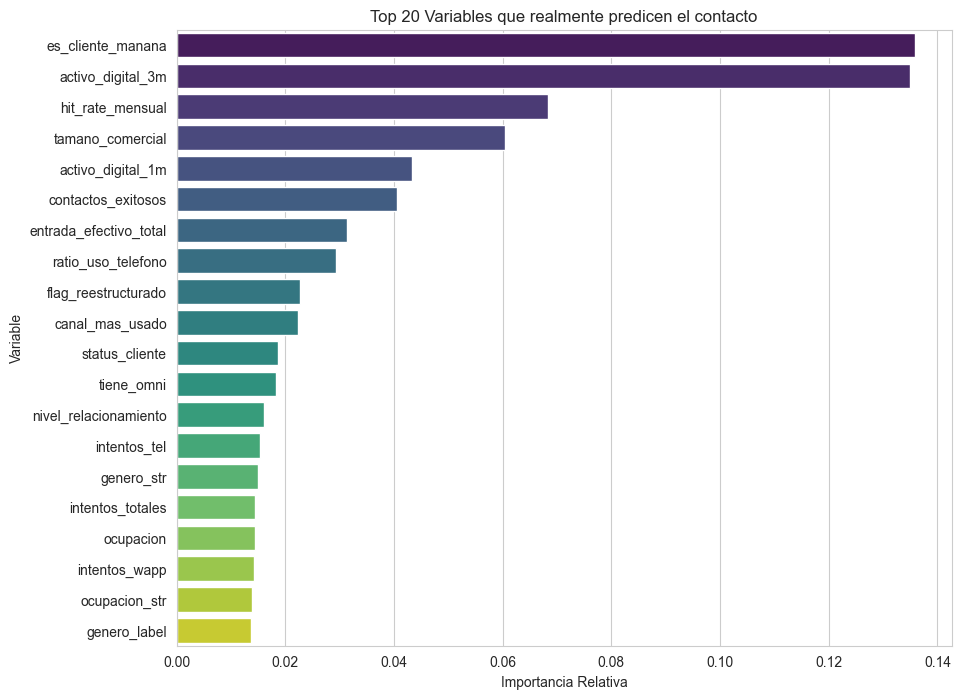


Top 10 Variables Ganadoras:
                   feature  importance
44       es_cliente_manana    0.135810
30       activo_digital_3m    0.134875
42        hit_rate_mensual    0.068282
18        tamano_comercial    0.060440
29       activo_digital_1m    0.043366
38      contactos_exitosos    0.040624
27  entrada_efectivo_total    0.031288
43      ratio_uso_telefono    0.029323
24     flag_reestructurado    0.022769
20         canal_mas_usado    0.022352


In [15]:
print("--- SCRIPT 5: Relevancia de variables ---")

# Extraemos la importancia de las variables
importances = pd.DataFrame({
    'feature': features,
    'importance': clf.feature_importances_
}).sort_values(by='importance', ascending=False)

# Visualización
plt.figure(figsize=(10, 8))
sns.barplot(data=importances.head(20), x='importance', y='feature', palette='viridis')
plt.title('Top 20 Variables que realmente predicen el contacto')
plt.xlabel('Importancia Relativa')
plt.ylabel('Variable')
plt.show()

print("\nTop 10 Variables Ganadoras:")
print(importances.head(10))

2.6 Entregables finales

In [18]:
print("--- GENERANDO ENTREGABLES FINALES ---")

import pandas as pd
import numpy as np
from pathlib import Path

# 1. Rutas
BASE_DIR = Path.cwd().parent
RAW_DIR = BASE_DIR / "data" / "raw"
OUTPUT_DIR = BASE_DIR / "outputs"
OUTPUT_DIR.mkdir(exist_ok=True)

try:
    # 2. Referencia al modelo y datos de entrada
    mi_modelo = clf 
    mis_datos_oot = X_oot.copy() 

    # --- Evitar error de categorias desconocidas
    cat_cols = mis_datos_oot.select_dtypes(include=['category', 'object']).columns
    
    if 'X_train' in locals():
        for col in cat_cols:
            categorias_entrenamiento = set(X_train[col].unique())
            # Convertimos valores nuevos en NaN para que XGBoost los maneje internamente
            mis_datos_oot[col] = mis_datos_oot[col].apply(lambda x: x if x in categorias_entrenamiento else np.nan)
            if isinstance(X_train[col].dtype, pd.CategoricalDtype):
                mis_datos_oot[col] = mis_datos_oot[col].astype(X_train[col].dtype)

    # 3. Generación de Resultados: Predicción Binaria y Probabilidades
    print(" Calculando predicciones y probabilidades...")
    y_pred_final = mi_modelo.predict(mis_datos_oot)
    # Obtenemos la probabilidad de la clase positiva (mejor_canal_contacto = 1)
    y_prob_final = mi_modelo.predict_proba(mis_datos_oot)[:, 1]

    # 4. Carga de IDs
    df_ids_originales = pd.read_csv(
        RAW_DIR / "ids_prueba_ba_mejor_canal_contacto_oot.csv", 
        dtype={'ID': str}
    )

    # 5. CREACIÓN DE ENTREGABLE 1: Formato Kaggle (Binario)
    submission_kaggle = pd.DataFrame({
        'ID': df_ids_originales['ID'],
        'var_resp': y_pred_final.astype(int)
    })

    # 6. CREACIÓN DE ENTREGABLE 2: Formato de Gestión (Con Probabilidad)
    submission_gestion = submission_kaggle.copy()
    submission_gestion['prob'] = y_prob_final

    # 7. Guardado y Verificación
    archivo_kaggle = OUTPUT_DIR / "submission_final_kaggle.csv"
    archivo_gestion = OUTPUT_DIR / "resultado_prueba.csv"
    
    submission_kaggle.to_csv(archivo_kaggle, index=False)
    submission_gestion.to_csv(archivo_gestion, index=False)
    
    print(f"Archivo Kaggle listo: {archivo_kaggle}")
    print(f"Archivo con Probabilidades listo: {archivo_gestion}")

    print(f"\nDistribución de clases en la entrega:")
    print(submission_kaggle['var_resp'].value_counts())

except NameError:
    print("Error: Modelo 'clf' o datos 'X_oot' no encontrados.")
except Exception as e:
    print(f"Error inesperado: {e}")

--- GENERANDO ENTREGABLES FINALES ---
 Calculando predicciones y probabilidades...
Archivo Kaggle listo: c:\Users\Nicole\Documents\Proyecto_BA\outputs\submission_final_kaggle.csv
Archivo con Probabilidades listo: c:\Users\Nicole\Documents\Proyecto_BA\outputs\resultado_prueba.csv

Distribución de clases en la entrega:
var_resp
0    29640
1    12317
Name: count, dtype: int64
